In [2]:
from keras.layers import Input,Dense,Flatten,Dropout,GlobalAveragePooling2D,Conv2D,MaxPooling2D
from keras.models import Model,Sequential
from keras.applications.vgg16 import VGG16
from keras.applications.nasnet import NASNetLarge
from keras.applications.resnet50 import ResNet50
from keras import optimizers
from keras.callbacks import EarlyStopping
from glob import glob

In [3]:
base_pretrained_model = NASNetLarge(input_shape =  (331, 331, 3), include_top = False, weights = 'imagenet')
base_pretrained_model.trainable = False

343613440/343610240 [==============================] - 16s 0us/step


In [5]:
base_pretrained_model.summary()

Model: "NASNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 331, 331, 3)  0                                            
__________________________________________________________________________________________________
stem_conv1 (Conv2D)             (None, 165, 165, 96) 2592        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn1 (BatchNormalization)   (None, 165, 165, 96) 384         stem_conv1[0][0]                 
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 165, 165, 96) 0           stem_bn1[0][0]                   
_____________________________________________________________________________________________

In [4]:
model = Sequential()
model.add(base_pretrained_model )
model.add(Conv2D(64,(3,3)))
model.add(MaxPooling2D())
model.add(Dropout(0.3))                
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
NASNet (Model)               (None, 11, 11, 4032)      84916818  
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 9, 9, 64)          2322496   
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 4, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

In [15]:
for layer in base_pretrained_model.layers:
    if layer.name in ['activation_260','normal_concat_18','normal_add_5_18']:
        print('H')
        layer.trainable =True
    else:
        layer.trainable = False

H
H
H


In [16]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['accuracy'])

In [6]:
import pandas as pd
train = pd.read_csv('/floyd/home/Data/Train.csv')
train.head()

,File_Name,Category
0,10846.jpg,1
1,2360.jpg,1
2,17531.jpg,0
3,13254.jpg,1
4,15554.jpg,0


In [7]:
from sklearn.model_selection import train_test_split
Train,Val = train_test_split(train,test_size=0.2,random_state=42,stratify=train['Category'])

In [8]:
import shutil
cats = '/floyd/home/Data/Train/Cats/'
dogs = '/floyd/home//Data/Train/Dogs/'

In [9]:
from keras.preprocessing.image import ImageDataGenerator
train_dir = '/floyd/home/MH_Data/Train'
validation_dir = '/floyd/home/MH_Data/Val'
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=90,#40
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
validation_datagen = ImageDataGenerator(rescale=1./255)


In [10]:
train_generator = train_datagen.flow_from_directory(train_dir,target_size=(331,331),batch_size=20,class_mode='binary')
validation_generator = validation_datagen.flow_from_directory(validation_dir,target_size=(331,331),batch_size=20,class_mode='binary')

Found 7577 images belonging to 2 classes.
Found 1895 images belonging to 2 classes.


In [17]:
history = model.fit_generator(train_generator,steps_per_epoch=50,epochs=10,validation_data=validation_generator,validation_steps=10)

Epoch 1/10
50/50 [==============================] - 203s 4s/step - loss: 0.3062 - accuracy: 0.8670 - val_loss: 0.0454 - val_accuracy: 0.9950
Epoch 2/10
50/50 [==============================] - 108s 2s/step - loss: 0.1569 - accuracy: 0.9380 - val_loss: 0.0302 - val_accuracy: 1.0000
Epoch 3/10
50/50 [==============================] - 110s 2s/step - loss: 0.1598 - accuracy: 0.9438 - val_loss: 0.0023 - val_accuracy: 0.9950
Epoch 4/10
50/50 [==============================] - 109s 2s/step - loss: 0.1602 - accuracy: 0.9430 - val_loss: 0.0027 - val_accuracy: 1.0000
Epoch 5/10
50/50 [==============================] - 109s 2s/step - loss: 0.1802 - accuracy: 0.9430 - val_loss: 0.0027 - val_accuracy: 0.9950
Epoch 6/10
50/50 [==============================] - 109s 2s/step - loss: 0.1294 - accuracy: 0.9510 - val_loss: 0.0897 - val_accuracy: 0.9850
Epoch 7/10
50/50 [==============================] - 109s 2s/step - loss: 0.1308 - accuracy: 0.9530 - val_loss: 0.0060 - val_accuracy: 0.9850
Epoch 8/10
50

In [18]:
sub = pd.read_csv('/floyd/home/Data/Sample_Submission.csv')

In [19]:
from keras.preprocessing import image
import os
import numpy as np
test_img_tensor = []
for image_name in sub['File_Name'].values.tolist():
  img = image.load_img('/floyd/home/Data/Test'+"/"+image_name,target_size=(331,331))
  img_tensor = image.img_to_array(img)
  img_tensor = np.expand_dims(img_tensor,axis=0)
  img_tensor /=255.
  test_img_tensor.append(img_tensor[0])
test_img_tensor  = np.array(test_img_tensor)

In [14]:
sub.head()

,File_Name,Category
0,8121.jpg,1
1,15486.jpg,1
2,8132.jpg,1
3,16297.jpg,1
4,20838.jpg,1


In [20]:
test_img_tensor.shape

(4059, 331, 331, 3)

In [21]:
predictions = model.predict(test_img_tensor)


In [22]:
preds = []
for i in predictions:
    if i >= 0.5:
        preds.append(1)
    else:
        preds.append(0)

In [23]:
sub['Category'] = preds

In [24]:
sub.head()

,File_Name,Category
0,8121.jpg,0
1,15486.jpg,0
2,8132.jpg,0
3,16297.jpg,1
4,20838.jpg,1


In [25]:
sub.tail()

,File_Name,Category
4054,15376.jpg,0
4055,19489.jpg,1
4056,9762.jpg,0
4057,1423.jpg,0
4058,10488.jpg,0


In [26]:
sub.to_csv('sub_nasnetlarge2.csv',index=False)

Visualize Predictions

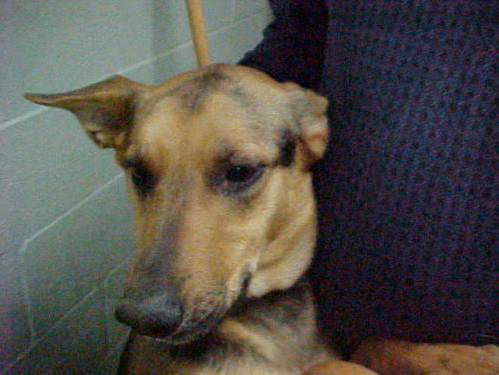

In [27]:
import PIL
import matplotlib.pyplot as plt
PIL.Image.open('/floyd/home/Data/Test/19489.jpg')

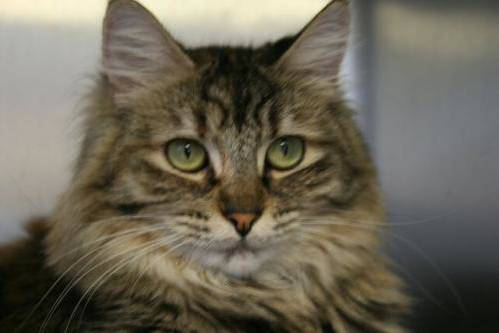

In [28]:
import PIL
import matplotlib.pyplot as plt
PIL.Image.open('/floyd/home/Data/Test/9762.jpg')


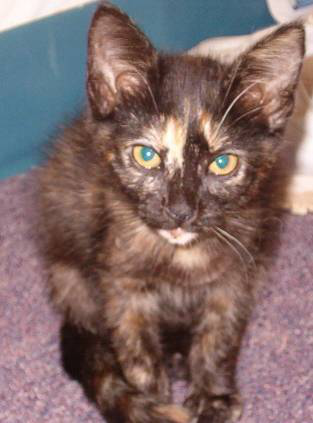

In [22]:
import PIL
import matplotlib.pyplot as plt
PIL.Image.open('/floyd/home/Data/Test/8121.jpg')



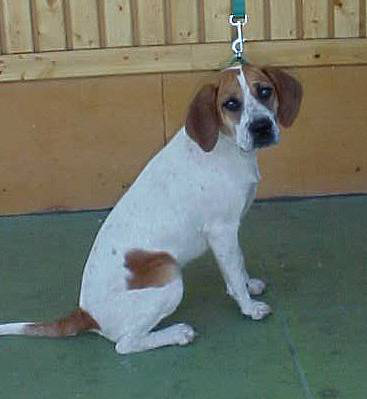

In [23]:
import PIL
import matplotlib.pyplot as plt
PIL.Image.open('/floyd/home/Data/Test/16297.jpg')
